## Import packages

In [1]:
%matplotlib inline
import keras
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.layers import Dense, Dropout, Flatten, AlphaDropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model
from keras import backend as K
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = [24, 24]

## ShowImages(images,gray=True): Helper function to Show images

In [3]:
def ShowImages(images,P,T,gray=True):
    """
    Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    size of each image must be same and a perfect square.
    """
    rows = int(np.sqrt(images.shape[0]))
    cols = rows
    while (rows * cols < images.shape[0]):
        rows = rows + 1
    x = images[0].shape[1]
    y = x
    fig = plt.figure()
    plt.suptitle('Images with their Predictions, True labels', fontsize=24)
    if gray:
        plt.gray()
    for n,image in enumerate(images):
        a = fig.add_subplot(rows,cols , n + 1)
        plt.imshow(images[n].reshape(x,y))
        plt.subplots_adjust(right=0.7,hspace = 0.6)
        plt.title(f'{P[n]}, {T[n]}')
        plt.axis('off')
    return

## Load MNIST Data Set

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Normalize the Data Set

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Catogerize the traget variable

In [6]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
modelh5 = 'Keras-MNIST.h5'
batch_size = 1024
num_classes = 10
epochs = 1

## Creating the Model

In [8]:
try:
    model = load_model(modelh5)
    print('Model loaded successfully')
except IOError:
    print('Running the model for the first time')
    model = Sequential()
    model.add(Conv2D(9, kernel_size=(14, 14),
                     activation='elu',
                     input_shape=input_shape,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(5, 5), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(81, (10, 10), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='selu'))
    model.add(AlphaDropout(0.4))
    model.add(Dense(64, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(amsgrad=True),
                  metrics=['accuracy'])

Model loaded successfully


## Train and evaluate the model

In [9]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
          #callbacks=[tensorboard])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 49s 824us/step - loss: 0.0174 - acc: 0.9951 - val_loss: 0.0311 - val_acc: 0.9920
Test loss: 0.031103821580730027
Test accuracy: 0.992


In [10]:
model.save(modelh5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 9)         1773      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 9)         36        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 9)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 9)         36        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 81)        72981     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 81)        324       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 81)          0         
__________

In [11]:
y_true, y_prob = y_train.argmax(axis=-1), model.predict(x_train)
y_pred = y_prob.argmax(axis=-1)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      5918
          7       1.00      1.00      1.00      6265
          8       1.00      1.00      1.00      5851
          9       1.00      1.00      1.00      5949

avg / total       1.00      1.00      1.00     60000



In [12]:
y_true, y_prob = y_test.argmax(axis=-1), model.predict(x_test)
y_pred = y_prob.argmax(axis=-1)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       0.99      1.00      0.99      1135
          2       0.99      0.99      0.99      1032
          3       1.00      0.99      0.99      1010
          4       0.99      1.00      0.99       982
          5       0.99      0.99      0.99       892
          6       1.00      0.99      1.00       958
          7       0.99      0.99      0.99      1028
          8       0.99      0.99      0.99       974
          9       0.99      0.98      0.99      1009

avg / total       0.99      0.99      0.99     10000



In [13]:
not_equal = np.not_equal(y_pred, y_true).nonzero()[0]

In [14]:
y_true[not_equal]

array([3, 2, 2, 5, 9, 3, 8, 6, 8, 7, 4, 3, 7, 9, 9, 7, 9, 3, 9, 5, 2, 9,
       5, 4, 1, 9, 3, 9, 5, 9, 9, 2, 2, 3, 5, 6, 9, 8, 3, 9, 9, 1, 7, 6,
       5, 8, 6, 7, 9, 9, 7, 2, 2, 9, 3, 9, 3, 9, 3, 9, 9, 0, 3, 5, 3, 9,
       7, 0, 8, 0, 1, 4, 4, 7, 9, 9, 2, 6, 9, 5], dtype=int64)

In [15]:
y_pred[not_equal]

array([5, 7, 7, 8, 7, 5, 9, 5, 1, 1, 6, 7, 2, 4, 5, 1, 8, 7, 5, 2, 8, 4,
       3, 9, 2, 8, 5, 4, 3, 1, 4, 0, 4, 6, 3, 1, 4, 0, 7, 7, 1, 2, 1, 4,
       0, 9, 8, 8, 4, 4, 1, 7, 0, 7, 2, 5, 2, 1, 5, 8, 4, 8, 8, 9, 2, 7,
       1, 7, 2, 8, 6, 8, 9, 2, 8, 7, 7, 3, 7, 6], dtype=int64)

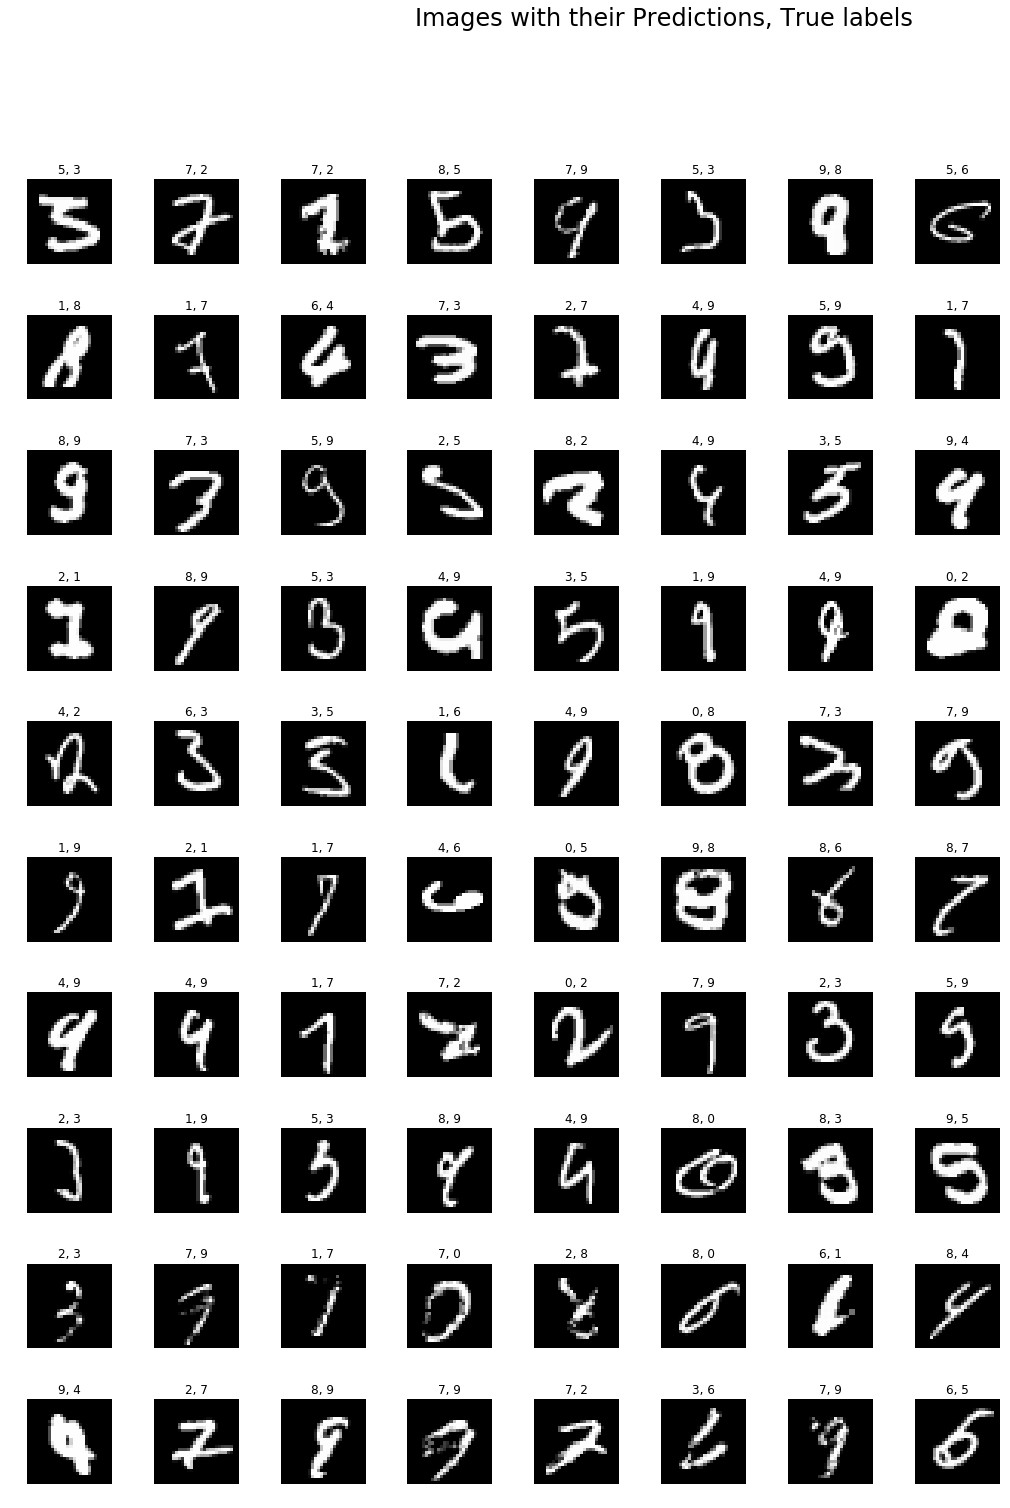

In [16]:
ShowImages(x_test[not_equal,:],y_pred[not_equal],y_true[not_equal],gray=True)